In [249]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib as mpl
import BiGLasso_Methods as bg
import GmGM
import scipy.stats as stats
import scipy.sparse as sparse
import igraph as ig
import mean_wrapper as mw

import os

# Prevent type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [250]:
# Load data
# Get all types of objects
data_dir = 'data/coil-20-proc/'
headers = {x.split('__')[0] for x in os.listdir(data_dir)}
print(headers)

{'obj9', 'obj12', 'obj7', 'obj5', 'obj20', 'obj16', 'obj4', 'obj10', 'obj17', 'obj19', 'obj13', 'obj6', 'obj15', 'obj8', 'obj3', 'obj2', 'obj14', 'obj18', 'obj11', 'obj1'}


In [251]:
# Every object has 72 frames, with 128x128 pixels
data: dict[str, np.ndarray] = {}
for object in headers:
    # Get all images of the object
    images = [x for x in os.listdir(data_dir) if x.split('__')[0] == object]
    frame_numbers = [int(x.split('__')[1].split('.')[0]) for x in images]
    data[object] = np.ndarray((len(images), 128, 128))
    for i, image in zip(frame_numbers, images):
        data[object][i] = plt.imread(data_dir + image)

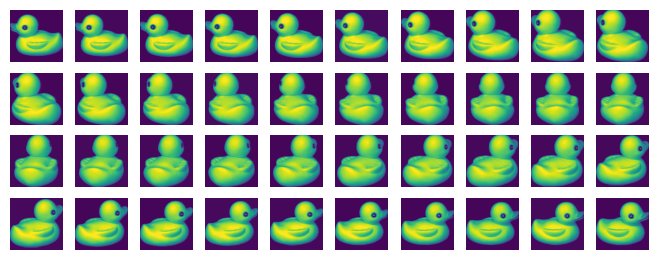

In [252]:
fig, axs = plt.subplots(ncols=10, nrows=4)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(data['obj1'][i])
    ax.axis('off')
# lower remove margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0.5)

In [253]:
dataset = GmGM.Dataset(
    dataset={'obj1': data['obj1']},
    structure={
        object: (f'frame', f'{object}_row', f'{object}_column')
        for object in headers
        if object == 'obj1'
    },
    batch_axes=None
)

In [254]:
results = GmGM.GmGM(
    dataset,
    to_keep=0.5,
    threshold_method="statistical-significance",
    n_comps=None,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=True,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    batch_size=1000
)
results

Centering...
Calculating eigenvectors...
	by calculating gram matrices and then eigendecomposing...
Calculating eigenvectors for axis='frame'
Calculating eigenvectors for axis='obj1_column'
Calculating eigenvectors for axis='obj1_row'
100% explained variance, since `n_comps` was not specified
Calculating eigenvalues...
@0: -3730197.7970885113 (-3730228.1112386812 + 30.314150170185354 + 0) ∆inf


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


Converged! (@42: -5044347.9378312705)
Recomposing sparse precisions...
Done!


Dataset(
	obj1: ('frame', 'obj1_row', 'obj1_column')
)
Axes(
	frame: 72
		Prior: None
		Gram: Calculated
		Eig: Calculated
	obj1_column: 128
		Prior: None
		Gram: Calculated
		Eig: Calculated
	obj1_row: 128
		Prior: None
		Gram: Calculated
		Eig: Calculated
)

Text(0.5, 1.0, 'Frames graph')

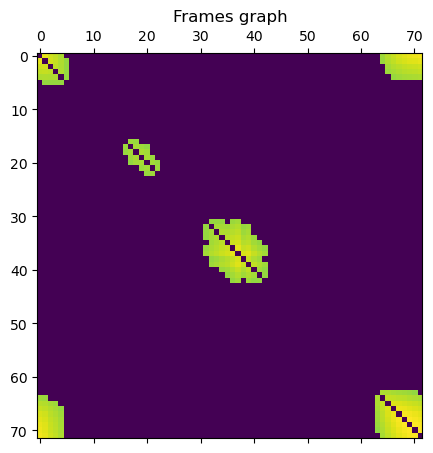

In [255]:
# Create a random graph
resmatrix = np.abs(results.precision_matrices['frame'].toarray())
np.fill_diagonal(resmatrix, 0)

# Keep only the top 144 of the edges
num_edges = (72 ** 2 - 72) / 2
percentile = 100 - 144 / num_edges  * 100
threshold = np.percentile(resmatrix, percentile)
resmatrix[resmatrix < threshold] = 0

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(resmatrix)
ax1.set_title("Frames graph")

# for (i, j), z in np.ndenumerate(frames_res):
#     ax1.text(
#         j,
#         i,
#         '{:0.1f}'.format(z),
#         ha='center',
#         va='center',
#         bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
#     )

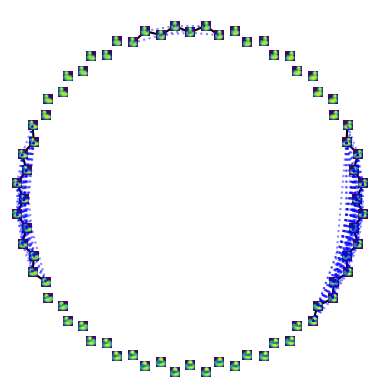

In [256]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 +  + 20 * (i % 2)
            scale_j = 450 +  + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out-figs/coil/gmgm.pdf', transparent=True, dpi=200)

In [257]:
dataset_tera = GmGM.Dataset(
    dataset={'obj1': data['obj1']}, # TeraLasso only supports one object
    structure={
        'obj1': (f'frame', f'row', f'column')
    },
    batch_axes=None
)
results_tera = bg.TeraLasso(
    dataset_tera,
    beta=5.4e-9,
    use_nonparanormal_skeptic=True,
    tol=1e-15
)
results_tera

Dataset(
	obj1: ('frame', 'row', 'column')
)
Axes(
	column: 128
		Prior: None
		Gram: Calculated
		Eig: Not calculated
	frame: 72
		Prior: None
		Gram: Calculated
		Eig: Not calculated
	row: 128
		Prior: None
		Gram: Calculated
		Eig: Not calculated
)

142.0


Text(0.5, 1.0, 'Frames graph')

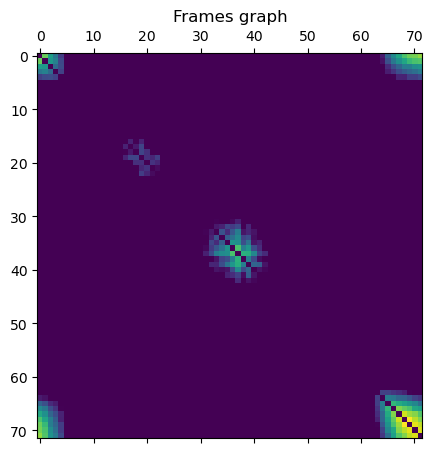

In [258]:
# Create a random graph
resmatrix_tera = np.abs(results_tera.precision_matrices['frame'].toarray())
np.fill_diagonal(resmatrix_tera, 0)

# Keep only the top 144 of the edges
print((resmatrix_tera > 0).sum() / 2)

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(resmatrix_tera)
ax1.set_title("Frames graph")

# for (i, j), z in np.ndenumerate(frames_res):
#     ax1.text(
#         j,
#         i,
#         '{:0.1f}'.format(z),
#         ha='center',
#         va='center',
#         bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
#     )

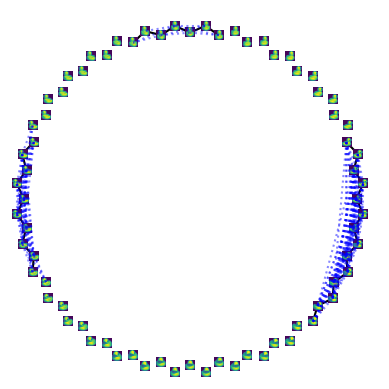

In [259]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix_tera[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 +  + 20 * (i % 2)
            scale_j = 450 +  + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out-figs/coil/teralasso.pdf', transparent=True, dpi=200)

In [260]:
dataset_gmgm_noncentral = GmGM.Dataset(
    dataset={'obj1': data['obj1']},
    structure={
        'obj1': (f'frame', f'row', f'column')
    },
    batch_axes=None
)
def gmgm_estimator(data):
    output = GmGM.GmGM(
        data,
        to_keep=0.5,
        threshold_method="statistical-significance",
        n_comps=None,
        verbose=False,
        centering_method=None,
        use_nonparanormal_skeptic=True,
        nonparanormal_evec_backend="COCA",
        readonly=False,
        calculate_explained_variance=True,
        batch_size=1000
    )
    return output.precision_matrices
NKS = mw.NoncentralKS(
    gmgm_estimator,
    ({"frame": np.zeros(72), "row": np.zeros(128), "column": np.zeros(128)}, 0),
    {"frame": np.eye(72), "row": np.eye(128), "column": np.eye(128)},
)
class result_container:
    # Jerry-rigged class to hold the result
    def __init__(self, precmats):
        self.precision_matrices = precmats

_, results_gmgm_noncentral = NKS.fit(dataset_gmgm_noncentral, verbose=True, tol=1e-3, max_iter=10)

Iteration: 1 (Change: 418.7542273353178)
Iteration: 2 (Change: 73.860699245718)
Iteration: 3 (Change: 2.5030089152608275)
Iteration: 4 (Change: 0.014496146813909616)
Converged in 5 iterations
Iteration: 5 (Change: 0.000339287250596258)


Text(0.5, 1.0, 'Frames graph')

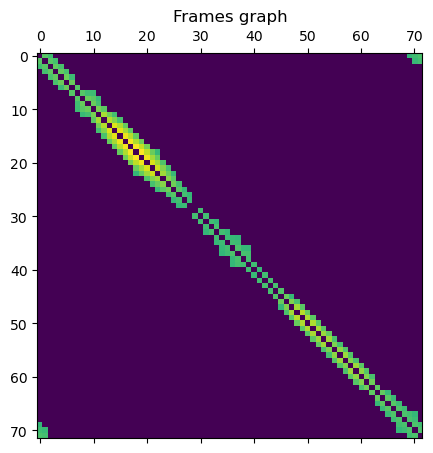

In [261]:
# Create a random graph
resmatrix_gmgm_noncentral = np.abs(results_gmgm_noncentral['frame'].toarray())
np.fill_diagonal(resmatrix_gmgm_noncentral, 0)

# Keep only the top 144 of the edges
num_edges = (72 ** 2 - 72) / 2
percentile = 100 - 144 / num_edges  * 100
threshold = np.percentile(resmatrix_gmgm_noncentral, percentile)
resmatrix_gmgm_noncentral[resmatrix_gmgm_noncentral < threshold] = 0

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(resmatrix_gmgm_noncentral)
ax1.set_title("Frames graph")

# for (i, j), z in np.ndenumerate(frames_res):
#     ax1.text(
#         j,
#         i,
#         '{:0.1f}'.format(z),
#         ha='center',
#         va='center',
#         bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
#     )

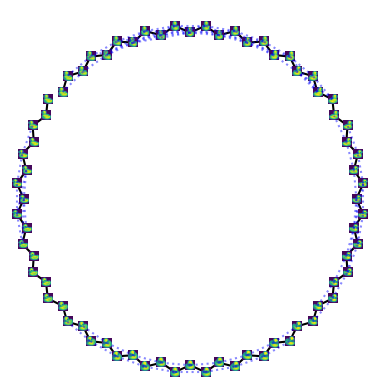

In [262]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix_gmgm_noncentral[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 +  + 20 * (i % 2)
            scale_j = 450 +  + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out-figs/coil/gmgm_noncentral.pdf', transparent=True, dpi=200)

In [263]:
dataset_tera_noncentral = GmGM.Dataset(
    dataset={'obj1': data['obj1']},
    structure={
        'obj1': (f'frame', f'row', f'column')
    },
    batch_axes=None
)
def tera_estimator(data):
    output = bg.TeraLasso(
        data,
        beta=2.69e-8,
        use_nonparanormal_skeptic=True,
        tol=1e-15
    )
    return output.precision_matrices
NKS = mw.NoncentralKS(
    tera_estimator,
    ({"frame": np.zeros(72), "row": np.zeros(128), "column": np.zeros(128)}, 0),
    {"frame": np.eye(72), "row": np.eye(128), "column": np.eye(128)},
)
class result_container:
    # Jerry-rigged class to hold the result
    def __init__(self, precmats):
        self.precision_matrices = precmats

_, results_tera_noncentral = NKS.fit(dataset_tera_noncentral, verbose=True, tol=1e-3, max_iter=10)

Iteration: 1 (Change: 689.687120527201)
Iteration: 2 (Change: 0.042617923345108215)
Converged in 3 iterations
Iteration: 3 (Change: 9.007990970512042e-06)


141.0


Text(0.5, 1.0, 'Frames graph')

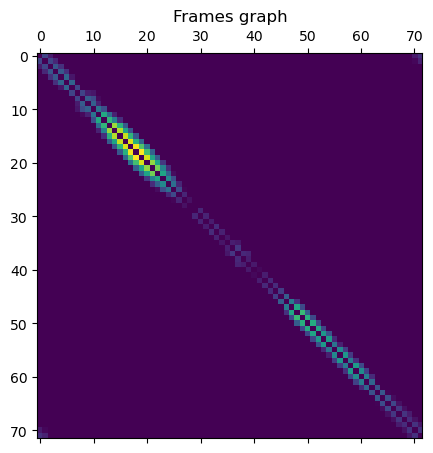

In [264]:
# Create a random graph
resmatrix_tera_noncentral = np.abs(results_tera_noncentral['frame'].toarray())
np.fill_diagonal(resmatrix_tera_noncentral, 0)

# Keep only the top 144 of the edges
print((resmatrix_tera_noncentral > 0).sum() / 2)

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(resmatrix_tera_noncentral)
ax1.set_title("Frames graph")

# for (i, j), z in np.ndenumerate(frames_res):
#     ax1.text(
#         j,
#         i,
#         '{:0.1f}'.format(z),
#         ha='center',
#         va='center',
#         bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
#     )

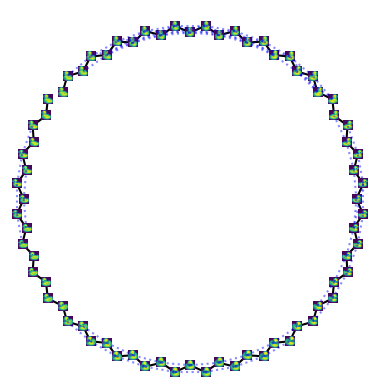

In [265]:
fig, ax = plt.subplots()
ax.axis('off')


for i in range(72):
    for j in range(72):
        if i >= j:
            continue
        if resmatrix_tera_noncentral[i, j] != 0:
            angle_1 = i/72 * 2 * np.pi
            angle_2 = j/72 * 2 * np.pi
            scale_i = 450 +  + 20 * (i % 2)
            scale_j = 450 +  + 20 * (j % 2)
            xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
            ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
            if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                ax.plot(xs, ys, color='black', zorder=0)
            else:
                ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

for i in range(72):
    img = ax.imshow(data["obj1"][i], zorder=10)
    transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
    transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
    transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
    transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
    img.set_transform(
        transform_rot
        + transform_scale
        + transform_move
        + transform_rerot
        + ax.transData
    )

ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)

fig.savefig('out-figs/coil/teralasso_noncentral.pdf', transparent=True, dpi=200)

# Put it all together

In [266]:
def add_base(resmat: np.ndarray, ax: plt.Axes) -> None:
    ax.axis('off')

    for i in range(72):
        for j in range(72):
            if i >= j:
                continue
            if resmat[i, j] != 0:
                angle_1 = i/72 * 2 * np.pi
                angle_2 = j/72 * 2 * np.pi
                scale_i = 450 +  + 20 * (i % 2)
                scale_j = 450 +  + 20 * (j % 2)
                xs = [scale_i * np.cos(angle_1) - 0.2*64, scale_j * np.cos(angle_2) - 0.2*64]
                ys = [scale_i * np.sin(angle_1) - 0.2*64, scale_j * np.sin(angle_2) - 0.2*64]
                if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                    ax.plot(xs, ys, color='black', zorder=0)
                else:
                    ax.plot(xs, ys, color='#0000ff77', zorder=20, linestyle=':')

    for i in range(72):
        img = ax.imshow(data["obj1"][i], zorder=10)
        transform_rot = mpl.transforms.Affine2D().rotate_deg(-i/72 * 360 + 180)
        transform_scale = mpl.transforms.Affine2D().scale(0.2, 0.2)
        transform_move = mpl.transforms.Affine2D().translate(450 + 20 * (i % 2), 0)
        transform_rerot = mpl.transforms.Affine2D().rotate_deg(i/72 * 360)
        img.set_transform(
            transform_rot
            + transform_scale
            + transform_move
            + transform_rerot
            + ax.transData
        )

    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)

def get_offbys(resmat: np.ndarray) -> tuple[int, int, int, int, int, int]:
    correct = 0
    off_by_1 = 0
    off_by_2 = 0
    off_by_3 = 0
    off_by_more = 0
    total = 0

    for i in range(72):
        for j in range(72):
            if i >= j:
                continue
            if resmat[i, j] != 0:
                total += 1
                if np.abs(i - j) == 1 or np.abs(i - j) == 71:
                    correct += 1
                elif np.abs(i - j) == 2 or np.abs(i - j) == 70:
                    off_by_1 += 1
                elif np.abs(i - j) == 3 or np.abs(i - j) == 69:
                    off_by_2 += 1
                elif np.abs(i - j) == 4 or np.abs(i - j) == 68:
                    off_by_3 += 1
                else:
                    off_by_more += 1
    return correct, off_by_1, off_by_2, off_by_3, off_by_more, total

GmGM:  (31, 28, 22, 17, 49, 147)
Noncentral GmGM:  (71, 56, 19, 1, 0, 147)
TeraLasso:  (28, 27, 22, 16, 49, 142)
Noncentral TeraLasso:  (71, 55, 15, 0, 0, 141)


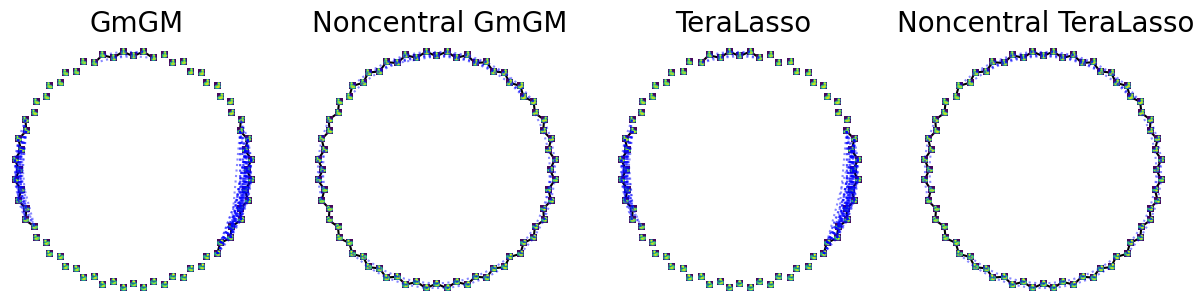

In [269]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 5))

resmatrices = [
    resmatrix,
    resmatrix_gmgm_noncentral,
    resmatrix_tera,
    resmatrix_tera_noncentral
]
names = ["GmGM", "Noncentral GmGM", "TeraLasso", "Noncentral TeraLasso"]
for ax, idx in zip(axs, range(4)):
    resmat = resmatrices[idx]
    add_base(resmat, ax)
    print(f"{names[idx]}: ", get_offbys(resmat))
    ax.set_title(names[idx], size=20)

fig.savefig('out-figs/coil/all-methods.pdf', transparent=True, dpi=200, bbox_inches='tight')